In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bismamaulana","key":"b08d7ecf449f30bc1ca62220b999a7fc"}'}

In [2]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 99% 1.02G/1.03G [00:18<00:00, 27.6MB/s]
100% 1.03G/1.03G [00:18<00:00, 58.6MB/s]


In [4]:
!mkdir asl-alphabet
!unzip asl-alphabet.zip -d asl-alphabet
!ls asl-alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_a

# Install Live CAM

In [5]:
!pip install tensorflow opencv-python matplotlib

## IMPORT LIBRARY

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os

# Gunakan GPU
print("GPU tersedia:", tf.config.list_physical_devices('GPU'))

GPU tersedia: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
import os
import shutil
import random

original_dir = '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
reduced_dir = '/content/asl_alphabet_train_reduced'

os.makedirs(reduced_dir, exist_ok=True)

images_per_class = 1000  # <--- ubah ke 800 kalau masih lambat, 1200 kalau mau lebih akurat

for class_name in os.listdir(original_dir):
    old_path = os.path.join(original_dir, class_name)
    new_path = os.path.join(reduced_dir, class_name)
    os.makedirs(new_path, exist_ok=True)

    images = os.listdir(old_path)
    selected = random.sample(images, min(images_per_class, len(images)))

    for img in selected:
        shutil.copy(os.path.join(old_path, img), os.path.join(new_path, img))

    print(f"{class_name}: {len(selected)} gambar")

print("Dataset kecil sudah siap!")

N: 1000 gambar
F: 1000 gambar
Y: 1000 gambar
R: 1000 gambar
C: 1000 gambar
P: 1000 gambar
S: 1000 gambar
H: 1000 gambar
E: 1000 gambar
L: 1000 gambar
M: 1000 gambar
V: 1000 gambar
W: 1000 gambar
Z: 1000 gambar
D: 1000 gambar
T: 1000 gambar
X: 1000 gambar
J: 1000 gambar
G: 1000 gambar
del: 1000 gambar
I: 1000 gambar
nothing: 1000 gambar
B: 1000 gambar
Q: 1000 gambar
K: 1000 gambar
space: 1000 gambar
A: 1000 gambar
O: 1000 gambar
U: 1000 gambar
Dataset kecil sudah siap!


## PREPROCESSING DATA

/tmp/ipython-input-1459515075.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


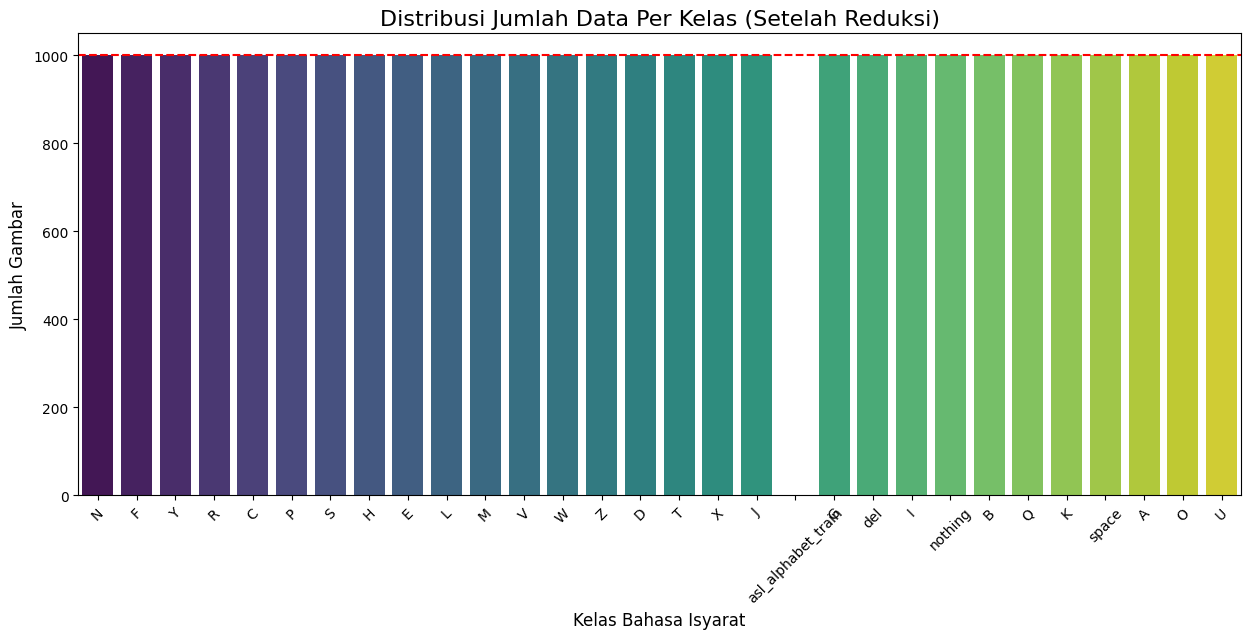

Total Kelas: 30
Total Gambar: 29000


In [104]:
import seaborn as sns

# Hitung jumlah gambar per folder
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path): # Pastikan itu folder
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

# Siapkan data untuk plot
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Membuat Bar Chart
plt.figure(figsize=(15, 6))
sns.barplot(x=classes, y=counts, palette="viridis")
plt.title("Distribusi Jumlah Data Per Kelas (Setelah Reduksi)", fontsize=16)
plt.xlabel("Kelas Bahasa Isyarat", fontsize=12)
plt.ylabel("Jumlah Gambar", fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=1000, color='r', linestyle='--') # Garis penanda 1000
plt.show()

print(f"Total Kelas: {len(classes)}")
print(f"Total Gambar: {sum(counts)}")

In [67]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# 1. Definisikan Path (Sesuaikan dengan lokasi folder dataset Anda di Colab)
# Path should now point to the reduced dataset folder
train_dir = '/content/asl_alphabet_train_reduced'

# Cek apakah path benar
if os.path.exists(train_dir):
    print("Folder ditemukan!", os.listdir(train_dir)[:5])
else:
    print("Folder tidak ditemukan, cek kembali path ekstraksi dataset Anda.")

# 2. Data Preprocessing & Augmentation
# Kita melakukan rescaling (0-255 menjadi 0-1) dan validasi split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # <-- Augmentasi dimulai
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

# Ukuran gambar dataset ASL biasanya 200x200, kita resize ke 64x64 agar ringan untuk training
target_size = (64, 64)
batch_size = 32

# Load Data Training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load Data Validasi
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Simpan label kelas untuk nanti
class_names = list(train_generator.class_indices.keys())
print("Kelas yang dideteksi:", class_names)

Folder ditemukan! ['N', 'F', 'Y', 'R', 'C']
Found 26100 images belonging to 30 classes.
Found 2900 images belonging to 30 classes.
Kelas yang dideteksi: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'asl_alphabet_train', 'del', 'nothing', 'space']


## Modeling

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flattening (Mengubah matriks 2D menjadi vektor 1D)
    Flatten(),

    # Fully Connected Layer
    Dense(512, activation='relu'),
    Dropout(0.5), # Mencegah overfitting

    # Output Layer (Disesuaikan menjadi 30 neuron karena generator mendeteksi 30 kelas)
    Dense(30, activation='softmax')
])

In [70]:
# Compile Model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30)             │        15,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,468,446 (9.42 MB)

 Trainable params: 2,468,446 (9.42 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Cek total file yang ditemukan generator
print(f"Total data training: {train_generator.n}")
print(f"Total data validasi: {validation_generator.n}")

# Estimasi per kelas (harus mendekati 900 train + 100 val jika split 10%)
print(f"Rata-rata per kelas: {train_generator.n / 29}")

Total data training: 26100
Total data validasi: 2900
Rata-rata per kelas: 900.0


In [72]:
print("Mulai Training...")

history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    verbose = 1
)

print("Training Selesai!")

Mulai Training...
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


816/816 ━━━━━━━━━━━━━━━━━━━━ 66s 77ms/step - accuracy: 0.0811 - loss: 3.2153 - val_accuracy: 0.3079 - val_loss: 2.2777
Epoch 2/15
816/816 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.3769 - loss: 1.9912 - val_accuracy: 0.5314 - val_loss: 1.4425
Epoch 3/15
816/816 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - accuracy: 0.5483 - loss: 1.3871 - val_accuracy: 0.5931 - val_loss: 1.1818
Epoch 4/15
816/816 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.6399 - loss: 1.0759 - val_accuracy: 0.6572 - val_loss: 0.9755
Epoch 5/15
816/816 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.7002 - loss: 0.9008 - val_accuracy: 0.6948 - val_loss: 0.8887
Epoch 6/15
816/816 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.7465 - loss: 0.7729 - val_accuracy: 0.7321 - val_loss: 0.7730
Epoch 7/15
816/816 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - accuracy: 0.7754 - loss: 0.6826 - val_accuracy: 0.7331 - val_loss: 0.7406
Epoch 8/15
816/816 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - accuracy: 0.7959 - loss: 0.6079 - val_accurac

In [74]:
# Simpan model ke format .h5
model.save('model_asl_huruf.h5')
print("Model berhasil disimpan! Cek di tab Files (ikon folder di kiri).")

Model berhasil disimpan! Cek di tab Files (ikon folder di kiri).


## TESTING MODEL

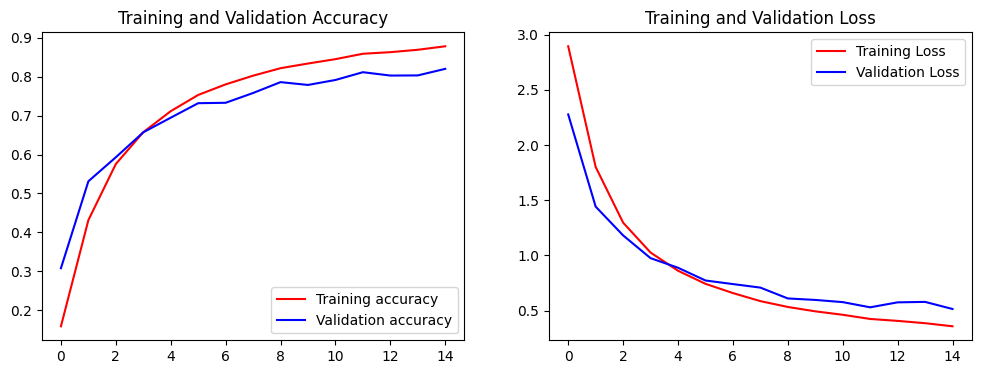

In [75]:
# Plot Akurasi dan Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [76]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
from PIL import Image
import io

# Fungsi untuk mengambil foto dari webcam browser
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  return binary

## SIMULASI MODEL

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


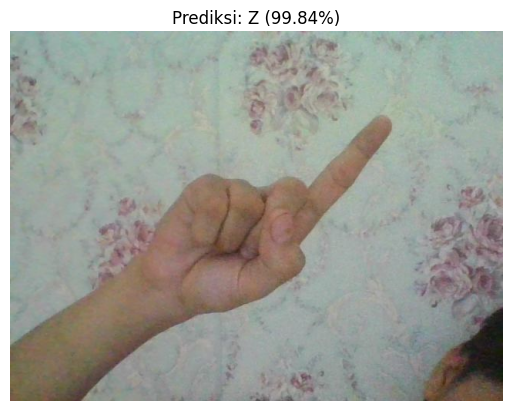

Hasil Deteksi: Huruf Z


In [97]:
from tensorflow.keras.preprocessing import image

try:
  # Ambil foto dari webcam
  filename = 'photo.jpg'
  image_binary = take_photo(filename)

  # Simpan file sementara
  with open(filename, 'wb') as f:
    f.write(image_binary)

  # Load gambar menggunakan OpenCV untuk visualisasi
  img_cv = cv2.imread(filename)

  # --- Preprocessing untuk Model ---
  # 1. Load gambar sesuai target size model (64x64)
  img = image.load_img(filename, target_size=(64, 64))

  # 2. Ubah ke array numpy
  x = image.img_to_array(img)

  # 3. Tambahkan dimensi batch (karena model butuh input [batch, height, width, channel])
  x = np.expand_dims(x, axis=0)

  # 4. Normalisasi (sama seperti saat training)
  x = x / 255.0

  # --- Prediksi ---
  classes = model.predict(x)
  result_index = np.argmax(classes)
  result_label = class_names[result_index]
  probability = np.max(classes)

  # Tampilkan Hasil
  plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
  plt.title(f"Prediksi: {result_label} ({probability*100:.2f}%)")
  plt.axis('off')
  plt.show()

  print(f"Hasil Deteksi: Huruf {result_label}")

except Exception as e:
  print(str(e))

In [98]:
from google.colab import files
files.download('model_asl_huruf.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>